# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload
import seaborn as sns

import sys
sys.path.insert(1, '../../t-recs/')
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo

sys.path.insert(1, '../')
import src.globals as globals
from wrapper.models.bubble import BubbleBurster
from src.utils import get_topic_clusters, create_embeddings, load_or_create_measurements_df, load_and_process_movielens, collect_parameters, load_measurements
from src.scoring_functions import top_k_reranking
from wrapper.metrics.evaluation_metrics import SerendipityMetric, DiversityMetric, NoveltyMetric, RecallMeasurement, UserMSEMeasurement
import src.globals as globals

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

ratings_df = pd.read_csv('../data/ml-100k/u.data', 
    sep="\t", 
    names=['UserID', 'MovieID', 'Rating', 'Timestamp']
)

movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_df = pd.read_csv('../data/ml-100k/u.item', sep="|", names=movie_cols, encoding='latin')

# display(movies_df.head(2))
# print(movies_df.shape)

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_23208/230766039.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [2]:
from sklearn.cluster import KMeans

def get_topic_clusters(binary_ratings_matrix, n_attrs:int=100, nmf_solver:str="mu"):
    """
    Creates clusters of movies based on their genre.
    Inputs:
        binary_ratings_matrix: a binary matrix of users and movies
        n_attrs: number of attributes to use in NMF
        nmf_solver: solver to use in NMF
    Outputs:
        clusters: a list of cluster assignments
    """
    # Create topic clusters
    #create co-occurence matrix from binary_interaction_matrix
    co_occurence_matrix = binary_ratings_matrix.T @ binary_ratings_matrix
    co_occurence_matrix

    # Matrix factorize co_occurence_matrix to get embeddings
    nmf_cooc = NMF(n_components=n_attrs, solver=nmf_solver)
    W_topics = nmf_cooc.fit_transform(co_occurence_matrix)

    # cluster W_topics
    kmeans = KMeans(n_clusters=100, random_state=random_state).fit(W_topics)

    # assign nearest cluster to observation
    cluster_ids = kmeans.predict(W_topics)

    return cluster_ids

In [3]:
from sklearn.decomposition import NMF

binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).to_numpy()

from lightfm.cross_validation import random_train_test_split
from scipy import sparse

# split data into train and test sets
train_interactions, test_interactions = random_train_test_split(sparse.csr_matrix(binary_ratings_matrix), test_percentage=0.2, random_state=random_state)
train_interactions = train_interactions.toarray()
test_interactions = test_interactions.toarray()

n_attrs=100
nmf = NMF(n_components=n_attrs, solver="mu")
user_representation = nmf.fit_transform(binary_ratings_matrix)
item_representation = nmf.components_
print(user_representation.shape, item_representation.shape)

num_topics = None
item_topics = get_topic_clusters(binary_ratings_matrix, n_attrs=n_attrs, nmf_solver="mu")
user_topic_history = None
item_count = None

users = Users(size=(943,100), repeat_interactions=False)

/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(
/Users/madisonthantu/miniforge3/envs/fairRS/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


(943, 100) (100, 1682)


# Trial & error for `top_k_reranking` score_fn function implementation

In [ ]:
sys.path.insert(1, '../')

from wrapper.models.bubble import BubbleBurster

In [ ]:
bubble = BubbleBurster(
    # num_users=number_of_users,
    # num_items=num_items,
    # num_attributes=number_of_attributes,
    item_topics=item_topics,
    user_representation=user_representation,
    item_representation=item_representation,
    actual_user_representation=users,
    record_base_state=True,
    # score_fn=next_k_myopic_scoring
)

In [ ]:
from wrapper.metrics import UserMSEMeasurement

bubble.add_metrics(MSEMeasurement())
print("These are the current metrics:")
print(bubble.metrics)

In [ ]:
import trecs.matrix_ops as mo
from numpy.random import RandomState

rs = RandomState(42)

In [ ]:
k = bubble.num_items_per_iter

pred_scores = mo.inner_product(bubble.predicted_user_profiles, bubble.predicted_item_attributes)

top_k_idxs = mo.top_k_indices(matrix=pred_scores, k=k, random_state=rs)
top_k_idxs

In [ ]:
for i in range(bubble.num_users):
    bool = np.array_equal(np.sort(pred_scores[i, top_k_idxs[i,:]])[-1::-1], pred_scores[i, top_k_idxs[i,:]])
    assert(bool)

In [ ]:
top_k_re_ranked_idxs = top_k_idxs[:,-1::-1]
top_k_re_ranked_scores = np.take_along_axis(pred_scores, top_k_idxs, axis=1)

# print(np.sort(top_k_re_ranked_scores)[0])
print(pred_scores[0, top_k_idxs[0]])

top_k_re_ranked_scores = top_k_re_ranked_scores[:, -1::-1]

assert(np.array_equal(top_k_re_ranked_scores[i,:], pred_scores[i, top_k_idxs[i,:]][-1::-1]))

re_ranked_scores = np.copy(pred_scores)
np.put_along_axis(re_ranked_scores, top_k_idxs, top_k_re_ranked_scores, axis=1)
print(re_ranked_scores[0, top_k_idxs[0]])#.shape

for i in range(bubble.num_users):
    # Checking that re_ranked_scores is equal to top_k_re_ranked_scores for each user
    assert(np.array_equal(re_ranked_scores[i, top_k_idxs[i,:]], top_k_re_ranked_scores[i,:]))
    # Checking that re_ranked_scores[top_k_idxs] is equal to the reverse of pred_scores[top_k_idxs]
    assert(np.array_equal(re_ranked_scores[i, top_k_idxs[i,:]], pred_scores[i,top_k_idxs[i,:]][-1::-1]))

In [ ]:
k = bubble.num_items_per_iter

pred_scores = mo.inner_product(bubble.predicted_user_profiles, bubble.predicted_item_attributes)
top_k_idxs = mo.top_k_indices(matrix=pred_scores, k=k, random_state=rs)

top_k_re_ranked_idxs = top_k_idxs[:,-1::-1]
top_k_re_ranked_scores = np.take_along_axis(pred_scores, top_k_idxs, axis=1)
top_k_re_ranked_scores = top_k_re_ranked_scores[:, -1::-1]

re_ranked_scores = np.copy(pred_scores)
np.put_along_axis(re_ranked_scores, top_k_idxs, top_k_re_ranked_scores, axis=1)

In [ ]:
for i in range(bubble.num_users):
    # Checking that re_ranked_scores is equal to top_k_re_ranked_scores for each user
    assert(np.array_equal(re_ranked_scores[i, top_k_idxs[i,:]], top_k_re_ranked_scores[i,:]))
    # Checking that re_ranked_scores[top_k_idxs] is equal to the reverse of pred_scores[top_k_idxs]
    assert(np.array_equal(re_ranked_scores[i, top_k_idxs[i,:]], pred_scores[i,top_k_idxs[i,:]][-1::-1]))

In [ ]:
print(re_ranked_scores[:, top_k_idxs][0, 0])#.shape)
print(re_ranked_scores[:, top_k_idxs][0])#.shape)

In [ ]:
pred_scores[:, top_k_idxs][0][:,-1::-1]

# Testing implementation of `top_k_reranking` score_fn function

In [ ]:
from src.scoring_functions import top_k_reranking

bubble = BubbleBurster(
    # num_users=number_of_users,
    # num_items=num_items,
    # num_attributes=number_of_attributes,
    item_topics=item_topics,
    user_representation=user_representation,
    item_representation=item_representation,
    actual_user_representation=users,
    record_base_state=True,
    score_fn=top_k_reranking
)

In [ ]:
from wrapper.metrics import UserMSEMeasurement

bubble.add_metrics(MSEMeasurement())
print("These are the current metrics:")
print(bubble.metrics)

In [ ]:
# np.array_equal(bubble.predicted_user_item_scores, bubble.predicted_scores.value)
bubble.predicted_user_item_scores

In [ ]:
import trecs.matrix_ops as mo
from numpy.random import RandomState

rs = RandomState(42)

k = bubble.num_items_per_iter

pred_scores = mo.inner_product(bubble.predicted_user_profiles, bubble.predicted_item_attributes)

top_k_idxs = mo.top_k_indices(matrix=pred_scores, k=k, random_state=rs)

for i in range(bubble.num_users):
    not_equal_idxs = np.where(np.equal(bubble.predicted_user_item_scores[i], pred_scores[i]) == False)
    assert(np.array_equal(np.unique(top_k_idxs[i]), np.unique(not_equal_idxs)))
    assert(np.array_equal(bubble.predicted_user_item_scores[i, top_k_idxs][i], pred_scores[i, top_k_idxs][i][-1::-1]))
    # break


In [ ]:
# now we run the model
bubble.run(timesteps=1)
measurements = bubble.get_measurements()

In [ ]:
import trecs.matrix_ops as mo
from numpy.random import RandomState

rs = RandomState(42)

k = bubble.num_items_per_iter

pred_scores = mo.inner_product(bubble.predicted_user_profiles, bubble.predicted_item_attributes)

top_k_idxs = mo.top_k_indices(matrix=pred_scores, k=k, random_state=rs)

for i in range(bubble.num_users):
    not_equal_idxs = np.where(np.equal(bubble.predicted_user_item_scores[i], pred_scores[i]) == False)
    assert(np.array_equal(np.unique(top_k_idxs[i]), np.unique(not_equal_idxs)))
    assert(np.array_equal(bubble.predicted_user_item_scores[i, top_k_idxs][i], pred_scores[i, top_k_idxs][i][-1::-1]))
    # break

In [ ]:
print(bubble.predicted_user_item_scores[i, top_k_idxs][i])

In [ ]:
pred_scores[i, top_k_idxs][i]

In [ ]:
bubble.predicted_user_item_scores[i, top_k_idxs][i]

# Running the simulation

In [ ]:
# def create_embeddings(binary_matrix, n_attrs:int=100, max_iter:int=100):
#     """
#     Creates embeddings for users and items based on their interactions.
#     Inputs:
#         binary_matrix: a binary matrix of users and movies
#         n_attrs: number of attributes to use in NMF
#         max_iter: number of iteration for NMF
#     Outputs:
#         user_representation: a matrix of user embeddings
#         item_representation: a matrix of item embeddings
#     """
#     print('Calculating embeddings...')
#     nmf = NMF(n_components=n_attrs, init='random', random_state=random_state, max_iter=max_iter)
#     user_representation = nmf.fit_transform(binary_matrix)
#     item_representation = nmf.components_
#     print('Calculated embeddings.')
#     return user_representation, item_representation

# def get_topic_clusters(cooccurence_matrix, n_clusters:int=100, n_attrs:int=100, max_iter:int=100):
#     """
#     Creates clusters of movies based on their genre.
#     Inputs:
#         binary_ratings_matrix: a binary matrix of users and movies
#         n_attrs: number of attributes to use in NMF
#         nmf_solver: solver to use in NMF
#     Outputs:
#         clusters: a list of cluster assignments
#     """
#     # Create topic clusters
#     #create co-occurence matrix from binary_interaction_matrix

#     print('Calculating clusters...')
#     # Matrix factorize co_occurence_matrix to get embeddings
#     nmf_cooc = NMF(n_components=n_attrs, max_iter=max_iter)
#     W_topics = nmf_cooc.fit_transform(cooccurence_matrix)

#     # cluster W_topics
#     cluster_ids = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state).fit_predict(W_topics)

#     print('Calculated clusters.')

#     return cluster_ids


In [4]:
n_attrs=20
max_iter=1000
n_clusters=20

binary_ratings_matrix = load_and_process_movielens(file_path='../data/ml-100k/u.data')

# Get user and item representations using NMF
# user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

# Define topic clusters using NMF
item_topics = get_topic_clusters(binary_ratings_matrix, n_attrs=n_attrs)

# Create user clusters based off how often they interacted with the same item
print('Calculating clusters...')
co_occurence_matrix = binary_ratings_matrix @ binary_ratings_matrix.T
print(co_occurence_matrix.shape)

# Matrix factorize co_occurence_matrix to get embeddings
nmf_cooc = NMF(n_components=n_attrs, max_iter=max_iter)
W_topics = nmf_cooc.fit_transform(co_occurence_matrix)

# cluster W_topics
cluster_ids = KMeans(n_clusters=n_clusters, max_iter=max_iter, random_state=random_state).fit_predict(W_topics)

print('Calculated clusters.')

Calculating clusters...
(943, 943)
Calculated clusters.


In [5]:
score_fn = ''
probabilistic = False
globals.ALPHA = 0.2
alpha = globals.ALPHA

# User parameters
drift = 0.2
attention_exp=1.5
pair_all=False

In [6]:
num_users = user_representation.shape[0]
num_items = item_representation.shape[1]
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

if pair_all:
    # All possible user pairs
    user_pairs = [(u_idx, v_idx) for u_idx in range(len(user_representation)) for v_idx in range(len(user_representation))]

else:
    # create user_pairs by pairing users only with others that are not in the same cluster
    user_pairs = []
    for u_idx in range(num_users):
        for v_idx in range(num_users):
            if cluster_ids[u_idx] != cluster_ids[v_idx]:
                user_pairs.append((u_idx, v_idx))
print(f'Number of user pairs: {len(user_pairs)}')
                
users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Number of items: 1682
Number of users: 943
Number of user pairs: 762348


In [7]:
item_representation.shape[1]

1682

In [8]:
mse = MSEMeasurement()
measurements_list = [
    InteractionMeasurement(), 
    mse,  
    InteractionSpread(), 
    InteractionSimilarity(pairs=user_pairs), 
    RecSimilarity(pairs=user_pairs), 
    SerendipityMetric(), 
    DiversityMetric(), 
    NoveltyMetric(),
    RecallMeasurement(),
    # MeanNumberOfTopics(),
]

In [9]:
item_topics.shape

(1682,)

In [10]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_topics,
    # 'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

config['score_fn'] = top_k_reranking

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [11]:
model = BubbleBurster(**config)

model.add_metrics(*measurements_list)

print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {model.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {model.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 1000)
- A randomly generated matrix of items of dimension (1000, 1682)


In [12]:
train_timesteps=5
model.startup_and_train(timesteps=train_timesteps)

100%|██████████| 5/5 [00:22<00:00,  4.55s/it]


In [13]:
run_timesteps=20
model.run(timesteps=run_timesteps)

  0%|          | 0/20 [00:00<?, ?it/s]

(943, 10)


  5%|▌         | 1/20 [01:38<31:05, 98.18s/it]

(943, 10)


 10%|█         | 2/20 [03:00<26:43, 89.11s/it]

(943, 10)


 15%|█▌        | 3/20 [04:11<22:48, 80.49s/it]

(943, 10)


 20%|██        | 4/20 [05:15<19:45, 74.08s/it]

(943, 10)


 25%|██▌       | 5/20 [06:16<17:20, 69.37s/it]

(943, 10)


 30%|███       | 6/20 [07:18<15:36, 66.89s/it]

(943, 10)


 35%|███▌      | 7/20 [08:23<14:19, 66.15s/it]

(943, 10)


 40%|████      | 8/20 [09:27<13:05, 65.49s/it]

(943, 10)


 45%|████▌     | 9/20 [10:32<12:00, 65.49s/it]

(943, 10)


 50%|█████     | 10/20 [11:38<10:56, 65.62s/it]

(943, 10)


 55%|█████▌    | 11/20 [12:45<09:54, 66.00s/it]

(943, 10)


 60%|██████    | 12/20 [13:52<08:50, 66.33s/it]

(943, 10)


 65%|██████▌   | 13/20 [14:58<07:44, 66.30s/it]

(943, 10)


 70%|███████   | 14/20 [16:05<06:38, 66.38s/it]

(943, 10)


 75%|███████▌  | 15/20 [17:11<05:31, 66.29s/it]

(943, 10)


 80%|████████  | 16/20 [18:17<04:24, 66.20s/it]

(943, 10)


 85%|████████▌ | 17/20 [19:24<03:18, 66.32s/it]

(943, 10)


 90%|█████████ | 18/20 [20:31<02:13, 66.65s/it]

(943, 10)


 95%|█████████▌| 19/20 [21:38<01:06, 66.76s/it]

(943, 10)


100%|██████████| 20/20 [22:45<00:00, 68.26s/it]


In [14]:
measurements = model.get_measurements()
df_measurements = pd.DataFrame(measurements)
df_measurements.head(5)

,interaction_histogram,mse,interaction_spread,interaction_similarity,rec_similarity,serendipity_metric,diversity_metric,novelty_metric,recall_at_k,timesteps
0,None,0.167915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,"[5.0, 0.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 3.0, ...",0.210884,-939.5,0.001417,0.003175,0.975928,0.946106,NaN,0.977731,1
2,"[2.0, 2.0, 2.0, 3.0, 0.0, 0.0, 1.0, 2.0, 2.0, ...",0.258063,0.0,0.001794,0.003114,0.974231,0.946400,NaN,0.991516,2
3,"[1.0, 1.0, 2.0, 3.0, 0.0, 0.0, 5.0, 3.0, 2.0, ...",0.307590,-0.5,0.002439,0.003147,0.972322,0.947355,NaN,0.993637,3
4,"[2.0, 1.0, 3.0, 2.0, 1.0, 2.0, 4.0, 4.0, 1.0, ...",0.356161,0.0,0.003172,0.003125,0.972322,0.944798,NaN,0.991516,4


In [21]:
type(df_measurements['timesteps'].values[0])

numpy.int64

In [27]:
def plot_measurements(df):
    
    fig, ax = plt.subplots(3, 3, figsize=(15, 15))
    fig.tight_layout(pad=5.0)

    # plot rec_similarity with timesteps on x axis
    legend_lines, legend_names = [], []
    # for i, df in enumerate(dfs):
    ts = df['timesteps']
    # name = parameters_df.loc[i, 'model_name']
    # if not np.isnan(parameters_df.loc[i, 'Lambda']):
    #      name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})" 
    # legend_names.append(name)
    ax[0,0].plot(ts, df['mse'], label='mse')
    ax[0,1].plot(ts, df['rec_similarity'], label='rec_similarity')
    ax[0,2].plot(ts, df['interaction_similarity'], label='interaction_similarity')
    ax[1,0].plot(ts, df['serendipity_metric'], label='serendipity_metric')
    ax[1,1].plot(ts, df['novelty_metric'], label='novelty_metric')
    line, = ax[1,2].plot(ts, df['diversity_metric'], label='diversity_metric')
    legend_lines.append(line)
    
    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    ax[0, 0].set_title('Mean Squared Error')
    ax[0, 0].set_ylabel('MSE')
    
    ax[0, 1].set_title('Recommendation similarity')
    ax[0, 1].set_ylabel('Similarity')
    
    ax[0, 2].set_title('Interaction Similarity')
    ax[0, 2].set_ylabel('Jaccard Similarity')
    
    ax[1, 0].set_title('Serendipity')
    ax[1, 0].set_ylabel('Serendipity')
    
    ax[1, 1].set_title('Novelty')
    ax[1, 1].set_ylabel('Novelty')

    ax[1, 2].set_title('Diversity')
    ax[1, 2].set_ylabel('Diversity')

    ax[2, 0].set_title('Recall')
    ax[2, 0].set_ylabel('Recall')

    
    fig.legend(legend_lines, legend_names, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))

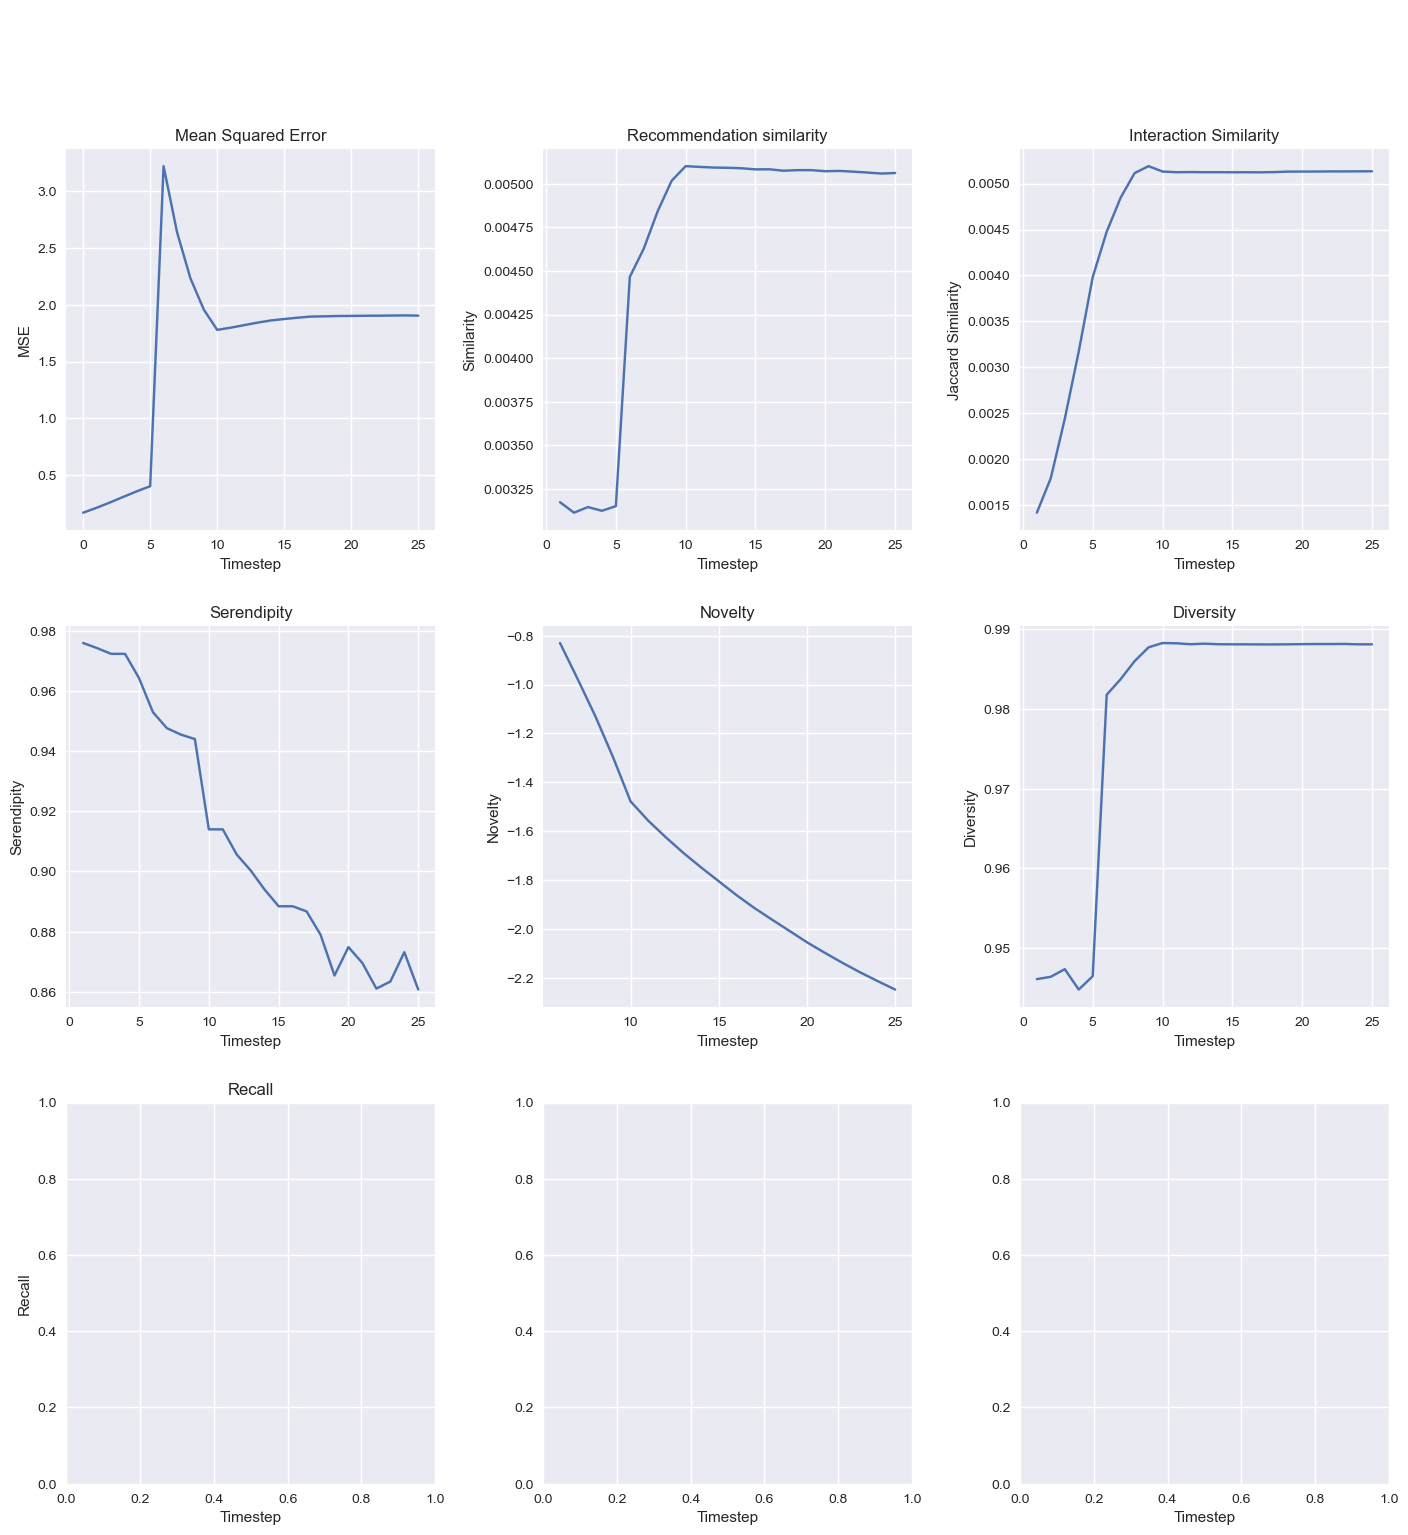

In [28]:
plot_measurements(df_measurements)